# Preprocessing

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import re
import random
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Ridge, RidgeCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor

In [2]:
# from `input.ipynb`

from dataclasses import dataclass

import numpy as np
import pandas as pd

# Helper class
@dataclass
class Note:
    note: int = 0       # The pitch
    octave: int = 0     # The (Midi) octave
    rest: int = 0       # Whether the note is a rest
    duration: int = 0   # The duration of the note (in 1/16 second intervals)

# Options for creating the dataframe. VOICE = which voice to pick, LAG = how many periods to lag for.
VOICE = 0
LAG = 8

# Import the csv
piano_input = pd.read_csv('F.txt', sep='\t', header=None)

# Transform piano key pitch (A0 = 1) to Midi pitch (A0 = 21)
# Different sources say different numbers for A0. Might be 9 or 21. :| 9 seems to be A(-1) generally though.
# If we map octave -1 to index 0 (which is the easiest probably), then we need A0 = 21.
midi_input = piano_input.where(piano_input == 0, piano_input + 20)
# Take the voice we are working on
voice_input = midi_input.iloc[:, VOICE]

# Create an output dataframe
notes = []
# Process the first note
cur = Note(voice_input[0] % 12, voice_input[0] // 12, 1 if voice_input[0] == 0 else 0, 1)

# Process the rest of the notes
for entry in voice_input[1:]:
    note = entry % 12
    octv = entry // 12
    if cur.note == note and cur.octave == octv:
        cur.duration += 1
    else:
        notes.append(cur)
        cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

# Pandas can automatically convert a list of dataclass objects to dataframes!
notes_df = pd.DataFrame(notes)

# Create a lagged input dataframe
notes_lagged_df = notes_df.copy()

for lag in range(1, LAG + 1):
    lagged = notes_df.shift(lag)
    lagged.columns = [f'{col_name}_lag{lag}' for col_name in notes_df.columns]
    notes_lagged_df = pd.concat((notes_lagged_df, lagged), axis=1)

# Drop rows containing NA (i.e. the first LAG rows basically)
notes_lagged_df = notes_lagged_df.dropna()

# Show first 10 notes
notes_lagged_df.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag6,duration_lag6,note_lag7,octave_lag7,rest_lag7,duration_lag7,note_lag8,octave_lag8,rest_lag8,duration_lag8
8,0,7,0,12,11.0,6.0,0.0,4.0,9.0,6.0,...,0.0,16.0,9.0,6.0,0.0,8.0,0.0,0.0,1.0,248.0
9,2,7,0,4,0.0,7.0,0.0,12.0,11.0,6.0,...,0.0,16.0,2.0,7.0,0.0,16.0,9.0,6.0,0.0,8.0
10,7,6,0,8,2.0,7.0,0.0,4.0,0.0,7.0,...,0.0,16.0,0.0,7.0,0.0,16.0,2.0,7.0,0.0,16.0
11,6,6,0,8,7.0,6.0,0.0,8.0,2.0,7.0,...,0.0,16.0,2.0,7.0,0.0,16.0,0.0,7.0,0.0,16.0
12,7,6,0,8,6.0,6.0,0.0,8.0,7.0,6.0,...,0.0,12.0,4.0,7.0,0.0,16.0,2.0,7.0,0.0,16.0
13,8,6,0,8,7.0,6.0,0.0,8.0,6.0,6.0,...,0.0,4.0,9.0,6.0,0.0,12.0,4.0,7.0,0.0,16.0
14,9,6,0,2,8.0,6.0,0.0,8.0,7.0,6.0,...,0.0,12.0,11.0,6.0,0.0,4.0,9.0,6.0,0.0,12.0
15,0,7,0,4,9.0,6.0,0.0,2.0,8.0,6.0,...,0.0,4.0,0.0,7.0,0.0,12.0,11.0,6.0,0.0,4.0
16,11,6,0,2,0.0,7.0,0.0,4.0,9.0,6.0,...,0.0,8.0,2.0,7.0,0.0,4.0,0.0,7.0,0.0,12.0
17,0,7,0,12,11.0,6.0,0.0,2.0,0.0,7.0,...,0.0,8.0,7.0,6.0,0.0,8.0,2.0,7.0,0.0,4.0


# Models

Change here: duration also as categorical

In [3]:
dfV1 = notes_lagged_df
# columns as categories or contineous variables
cate_cols = [i for i in dfV1.columns.values if (re.search('note', i) or re.search('rest', i) or re.search('duration', i))]
cont_cols = [i for i in dfV1.columns.values if (re.search('octave', i))]
print(cate_cols)
print(cont_cols)

['note', 'rest', 'duration', 'note_lag1', 'rest_lag1', 'duration_lag1', 'note_lag2', 'rest_lag2', 'duration_lag2', 'note_lag3', 'rest_lag3', 'duration_lag3', 'note_lag4', 'rest_lag4', 'duration_lag4', 'note_lag5', 'rest_lag5', 'duration_lag5', 'note_lag6', 'rest_lag6', 'duration_lag6', 'note_lag7', 'rest_lag7', 'duration_lag7', 'note_lag8', 'rest_lag8', 'duration_lag8']
['octave', 'octave_lag1', 'octave_lag2', 'octave_lag3', 'octave_lag4', 'octave_lag5', 'octave_lag6', 'octave_lag7', 'octave_lag8']


## model for `rest`

In [4]:
rcv_pipe_rest = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'rest' and i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
rcv_pipe_rest.fit(X = dfV1[dfV1.columns.drop(['rest', 'note', 'octave', 'duration'])], y = dfV1['rest'])
rcv_pipe_rest['ridgeclassifiercv'].alpha_

10.0

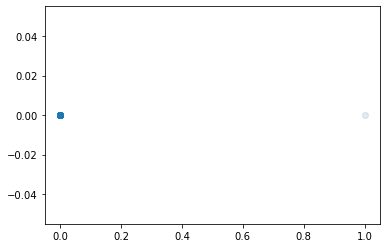

In [5]:
rcv_pipe_rest_pred = rcv_pipe_rest.predict(X = dfV1[dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1.rest, rcv_pipe_rest_pred, alpha = 0.01)
# it never predicts a rest, which is fine?
# then we don't need to predict duration for rests.

## model for `octave`

In [6]:
rcv_pipe_octave = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    # here we need to transform the outcome to the closest integer.
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10),
        func=lambda x : x,
        inverse_func=lambda x: np.round(x)
    )
)
## here we need to filter out rests
rcv_pipe_octave.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])], 
                    y = dfV1[dfV1.rest != 1]['octave'])
rcv_pipe_octave['transformedtargetregressor'].regressor_.alpha_

100.0

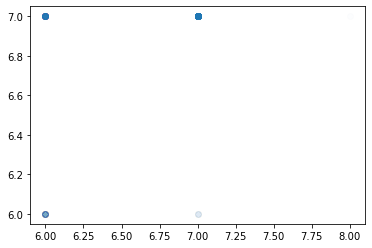

In [7]:
rcv_pipe_octave_pred = rcv_pipe_octave.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['octave'], rcv_pipe_octave_pred, alpha = 0.01)

## model for `note`

In [8]:
rcv_pipe_note = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_note.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])], 
                  y = dfV1[dfV1.rest != 1]['note'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


10.0

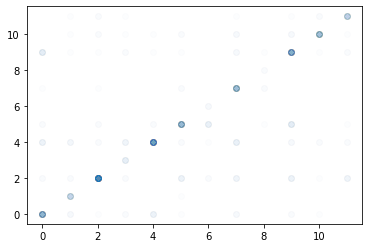

In [9]:
rcv_pipe_note_pred = rcv_pipe_note.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['note'], rcv_pipe_note_pred, alpha = 0.01)

## model for `duration`

In [10]:
rcv_pipe_duration = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_duration.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])], 
                    y = dfV1[dfV1.rest != 1]['duration'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


10.0

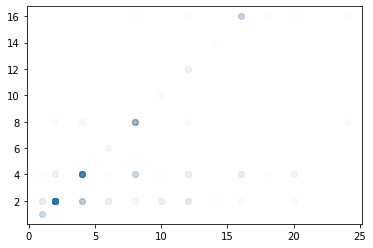

In [11]:
rcv_pipe_duration_pred = rcv_pipe_duration.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['duration'], rcv_pipe_duration_pred, alpha = 0.01)
# this looks better.

# Prediction

In [12]:
# deterministic
dfV1_pred = dfV1
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    dfV1_pred.iloc[-1,3] = temp_v1_duration

In [21]:
# stochastic
dfV1_pred = dfV1
random.seed(1614)
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    # temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    d = rcv_pipe_note.decision_function(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_note = random.choices(rcv_pipe_note.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    # temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    d = rcv_pipe_duration.decision_function(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    while(temp_v1_duration > 12):
        temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,3] = temp_v1_duration

In [22]:
dfV1_pred.tail(50)
# duration too long

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag6,duration_lag6,note_lag7,octave_lag7,rest_lag7,duration_lag7,note_lag8,octave_lag8,rest_lag8,duration_lag8
657,11.0,7.0,0.0,2.0,0.0,7.0,0.0,8.0,8.0,7.0,...,0.0,8.0,4.0,7.0,0.0,2.0,3.0,7.0,0.0,2.0
658,2.0,7.0,0.0,2.0,11.0,7.0,0.0,2.0,0.0,7.0,...,0.0,4.0,11.0,7.0,0.0,8.0,4.0,7.0,0.0,2.0
659,0.0,7.0,0.0,2.0,2.0,7.0,0.0,2.0,11.0,7.0,...,0.0,8.0,6.0,7.0,0.0,4.0,11.0,7.0,0.0,8.0
660,4.0,7.0,0.0,8.0,0.0,7.0,0.0,2.0,2.0,7.0,...,0.0,6.0,1.0,7.0,0.0,8.0,6.0,7.0,0.0,4.0
661,5.0,7.0,0.0,12.0,4.0,7.0,0.0,8.0,0.0,7.0,...,0.0,2.0,2.0,7.0,0.0,6.0,1.0,7.0,0.0,8.0
662,1.0,7.0,0.0,4.0,5.0,7.0,0.0,12.0,4.0,7.0,...,0.0,8.0,8.0,7.0,0.0,2.0,2.0,7.0,0.0,6.0
663,6.0,7.0,0.0,12.0,1.0,7.0,0.0,4.0,5.0,7.0,...,0.0,2.0,0.0,7.0,0.0,8.0,8.0,7.0,0.0,2.0
664,11.0,7.0,0.0,8.0,6.0,7.0,0.0,12.0,1.0,7.0,...,0.0,2.0,11.0,7.0,0.0,2.0,0.0,7.0,0.0,8.0
665,11.0,7.0,0.0,2.0,11.0,7.0,0.0,8.0,6.0,7.0,...,0.0,2.0,2.0,7.0,0.0,2.0,11.0,7.0,0.0,2.0
666,4.0,7.0,0.0,2.0,11.0,7.0,0.0,2.0,11.0,7.0,...,0.0,8.0,0.0,7.0,0.0,2.0,2.0,7.0,0.0,2.0


In [23]:
len(dfV1_pred)
len(dfV1)

607

In [24]:
from midiutil import MIDIFile

mymidi = MIDIFile(numTracks=1)
mymidi.addTempo(track = 0, time = 0, tempo = 60*8)
current_time = 0
for i in range(580, len(dfV1_pred)):
    for j in range(1):
        current_note = int(dfV1_pred.iloc[i,0] + dfV1_pred.iloc[i,1]*12)
        if(dfV1_pred.iloc[i,2] == 1):
            current_time = current_time + int(dfV1_pred.iloc[i,3])
            continue
        mymidi.addNote(track = j, channel = 0, pitch = current_note, time = current_time, duration = int(dfV1_pred.iloc[i,3]), volume = 100)
        current_time = current_time + int(dfV1_pred.iloc[i,3])
        
with open("pred.mid", "wb") as output_file:
    mymidi.writeFile(output_file)

## The same procedure, but for Little Star

In [17]:
# from `input.ipynb`

from dataclasses import dataclass

import numpy as np
import pandas as pd

# Helper class
@dataclass
class Note:
    note: int = 0       # The pitch
    octave: int = 0     # The (Midi) octave
    rest: int = 0       # Whether the note is a rest
    duration: int = 0   # The duration of the note (in 1/16 second intervals)

# Options for creating the dataframe. VOICE = which voice to pick, LAG = how many periods to lag for.
VOICE = 0
LAG = 8

# Import the csv
piano_input = pd.read_csv('twinkle.txt', sep='\t', header=None)

# Transform piano key pitch (A0 = 1) to Midi pitch (A0 = 21)
# Different sources say different numbers for A0. Might be 9 or 21. :| 9 seems to be A(-1) generally though.
# If we map octave -1 to index 0 (which is the easiest probably), then we need A0 = 21.
midi_input = piano_input.where(piano_input == 0, piano_input + 20)
# Take the voice we are working on
voice_input = midi_input.iloc[:, VOICE]

# Create an output dataframe
notes = []
# Process the first note
cur = Note(voice_input[0] % 12, voice_input[0] // 12, 1 if voice_input[0] == 0 else 0, 1)

# Process the rest of the notes
for entry in voice_input[1:]:
    note = entry % 12
    octv = entry // 12
    if cur.note == note and cur.octave == octv:
        cur.duration += 1
    else:
        notes.append(cur)
        cur = Note(note, octv, 1 if note == 0 and octv == 0 else 0, 1)

# Pandas can automatically convert a list of dataclass objects to dataframes!
notes_df = pd.DataFrame(notes)

# Create a lagged input dataframe
notes_lagged_df = notes_df.copy()

for lag in range(1, LAG + 1):
    lagged = notes_df.shift(lag)
    lagged.columns = [f'{col_name}_lag{lag}' for col_name in notes_df.columns]
    notes_lagged_df = pd.concat((notes_lagged_df, lagged), axis=1)

# Drop rows containing NA (i.e. the first LAG rows basically)
notes_lagged_df = notes_lagged_df.dropna()

# Show first 10 notes
notes_lagged_df.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag6,duration_lag6,note_lag7,octave_lag7,rest_lag7,duration_lag7,note_lag8,octave_lag8,rest_lag8,duration_lag8
8,8,7,0,8,0.0,8.0,0.0,1.0,10.0,7.0,...,0.0,8.0,3.0,8.0,0.0,8.0,8.0,7.0,0.0,8.0
9,3,8,0,8,8.0,7.0,0.0,8.0,0.0,8.0,...,0.0,8.0,5.0,8.0,0.0,8.0,3.0,8.0,0.0,8.0
10,1,8,0,8,3.0,8.0,0.0,8.0,8.0,7.0,...,0.0,8.0,3.0,8.0,0.0,8.0,5.0,8.0,0.0,8.0
11,0,8,0,8,1.0,8.0,0.0,8.0,3.0,8.0,...,0.0,8.0,1.0,8.0,0.0,8.0,3.0,8.0,0.0,8.0
12,10,7,0,8,0.0,8.0,0.0,8.0,1.0,8.0,...,0.0,7.0,0.0,8.0,0.0,8.0,1.0,8.0,0.0,8.0
13,3,8,0,8,10.0,7.0,0.0,8.0,0.0,8.0,...,0.0,1.0,10.0,7.0,0.0,7.0,0.0,8.0,0.0,8.0
14,1,8,0,8,3.0,8.0,0.0,8.0,10.0,7.0,...,0.0,8.0,0.0,8.0,0.0,1.0,10.0,7.0,0.0,7.0
15,0,8,0,7,1.0,8.0,0.0,8.0,3.0,8.0,...,0.0,8.0,8.0,7.0,0.0,8.0,0.0,8.0,0.0,1.0
16,1,8,0,1,0.0,8.0,0.0,7.0,1.0,8.0,...,0.0,8.0,3.0,8.0,0.0,8.0,8.0,7.0,0.0,8.0
17,0,8,0,4,1.0,8.0,0.0,1.0,0.0,8.0,...,0.0,8.0,1.0,8.0,0.0,8.0,3.0,8.0,0.0,8.0


In [18]:
# stochastic
dfV1_twinkle = notes_lagged_df
random.seed(1614)
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_twinkle.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_twinkle.columns
    dfV1_twinkle = dfV1_twinkle.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_twinkle.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_twinkle.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_twinkle.iloc[-1,1] = temp_v1_octave
    # predict the next note
    # temp_v1_note = rcv_pipe_note.predict(X=dfV1_twinkle.tail(1).drop(columns = ['note', 'duration']))
    d = rcv_pipe_note.decision_function(X=dfV1_twinkle.tail(1).drop(columns = ['note', 'duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_note = random.choices(rcv_pipe_note.classes_, weights=probs[0])[0]
    dfV1_twinkle.iloc[-1,0] = temp_v1_note
    # predict the next duration
    # temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_twinkle.tail(1).drop(columns = ['duration']))
    d = 3.5*rcv_pipe_duration.decision_function(X=dfV1_twinkle.tail(1).drop(columns = ['duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    while(temp_v1_duration > 12):
        temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    dfV1_twinkle.iloc[-1,3] = temp_v1_duration

In [19]:
from midiutil import MIDIFile

mymidi = MIDIFile(numTracks=1)
mymidi.addTempo(track = 0, time = 0, tempo = 60*8)
current_time = 0
for i in range(len(dfV1_twinkle)):
    for j in range(1):
        current_note = int(dfV1_twinkle.iloc[i,0] + dfV1_twinkle.iloc[i,1]*12)
        print(current_time, current_note, int(dfV1_twinkle.iloc[i,3]))
        if(dfV1_twinkle.iloc[i,2] == 1):
            current_time = current_time + int(dfV1_twinkle.iloc[i,3])
            continue
        mymidi.addNote(track = j, channel = 0, pitch = current_note, time = current_time, duration = int(dfV1_twinkle.iloc[i,3]), volume = 100)
        current_time = current_time + int(dfV1_twinkle.iloc[i,3])
        
with open("twinkle_pred.mid", "wb") as output_file:
    mymidi.writeFile(output_file)

0 92 8
8 99 8
16 97 8
24 96 8
32 94 8
40 99 8
48 97 8
56 96 7
63 97 1
64 96 4
68 94 4
72 92 8
80 99 8
88 101 8
96 99 8
104 97 8
112 96 8
120 94 7
127 96 1
128 74 1
129 92 2
131 91 2
133 86 2
135 95 2
137 92 4
141 90 4
145 92 10
155 90 2
157 93 2
159 95 2
161 84 2
163 90 2
165 94 2
167 83 2
169 90 2
171 94 2
173 95 2
175 91 2
177 92 2
179 93 2
181 84 2
183 87 2
185 86 4
189 87 10
199 95 2
201 84 2
203 92 2
205 89 2
207 90 2
209 89 2
211 85 2
213 86 2
215 84 2
217 86 2
219 88 2
221 94 2
223 84 2
225 86 2
227 85 2
229 93 2
231 86 2
233 92 2
235 90 2
237 90 2
239 89 2
241 85 2
243 93 2
245 93 2
247 88 2
249 88 2
251 86 2
253 85 2
255 89 2
257 86 2
259 86 2
261 92 2
263 85 2
265 88 2
267 93 2
269 87 2
271 85 2
273 86 2
275 88 2
277 90 2
279 89 2
281 90 2
283 89 12
295 85 2
297 94 2
299 93 2
301 87 2
303 88 2
305 95 2
307 87 2
309 86 2
311 84 2
313 86 2
315 93 2
317 84 2
319 85 2
321 84 2
323 85 2
325 88 4
329 95 8
337 95 6
343 84 2
345 93 2
347 85 2
349 88 2
351 93 2
353 92 2
355 91 2
357 8

In [20]:
type(int(1)/4)

float